# Add Weighted Cross-Entropy Loss

In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))


In [4]:
import torch
from src.model import PlantDiseaseCNN
from src.data import get_loaders
from src.train import train
from collections import Counter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
train_loader, val_loader = get_loaders("../data/PlantVillage", img_size=224, batch_size=32)

# Init model
model = PlantDiseaseCNN(num_classes=15)

# Get label list from train_loader Subset
train_labels = [label for _, label in train_loader.dataset]

# Count how many samples per class
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())

# Inverse frequency weights
weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# New weighted loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Reuse same optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [5]:

# Train
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=4)



Epoch 1/4


Train Loss: 1.0227, Acc: 0.6829 | Val Loss: 0.6713, Acc: 0.7737

Epoch 2/4


Train Loss: 0.4116, Acc: 0.8674 | Val Loss: 0.3705, Acc: 0.8723

Epoch 3/4


Train Loss: 0.2590, Acc: 0.9187 | Val Loss: 0.2631, Acc: 0.9099

Epoch 4/4


Train Loss: 0.1514, Acc: 0.9503 | Val Loss: 0.2767, Acc: 0.9150


## Evaluate the Improved CNN Model (Confusion Matrix + ROC Curve)

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# Set model to eval mode
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Get class names
class_names = val_loader.dataset.dataset.classes


## Confusion Matrix

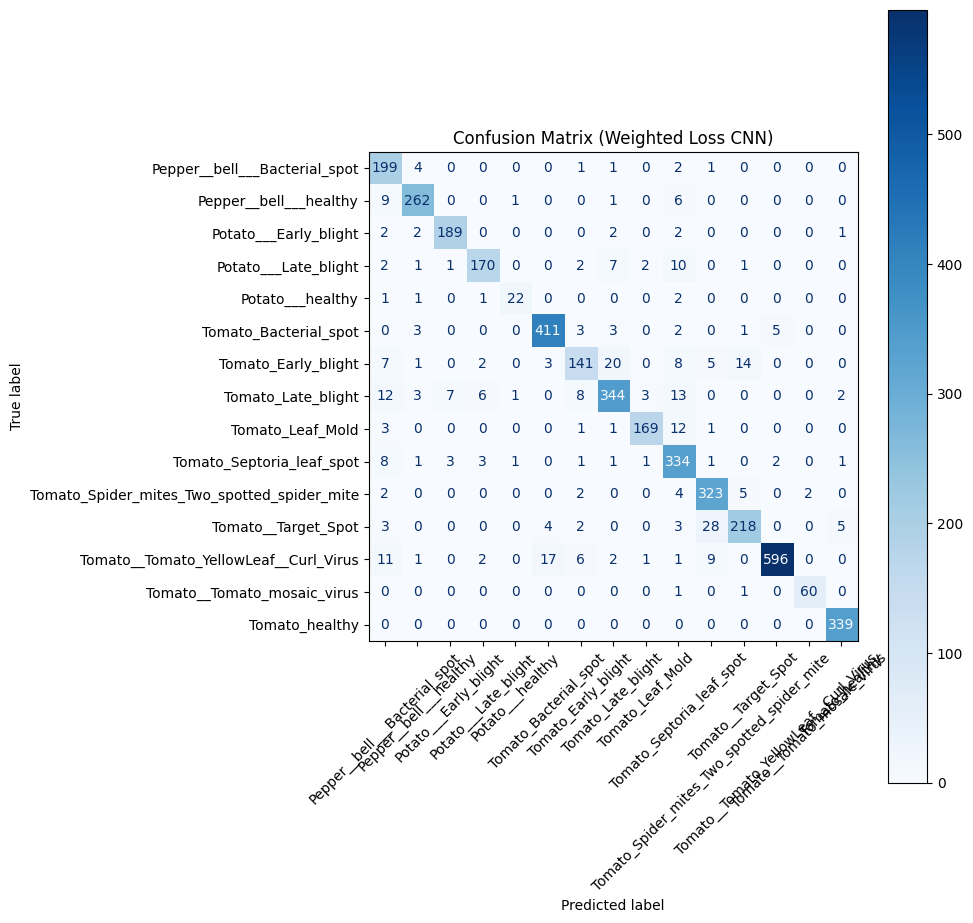

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix (Weighted Loss CNN)")
plt.tight_layout()
plt.savefig("../outputs/figures/confusion_matrix_cnn_weighted.png")
plt.show()

## ROC Curve (Multiclass)

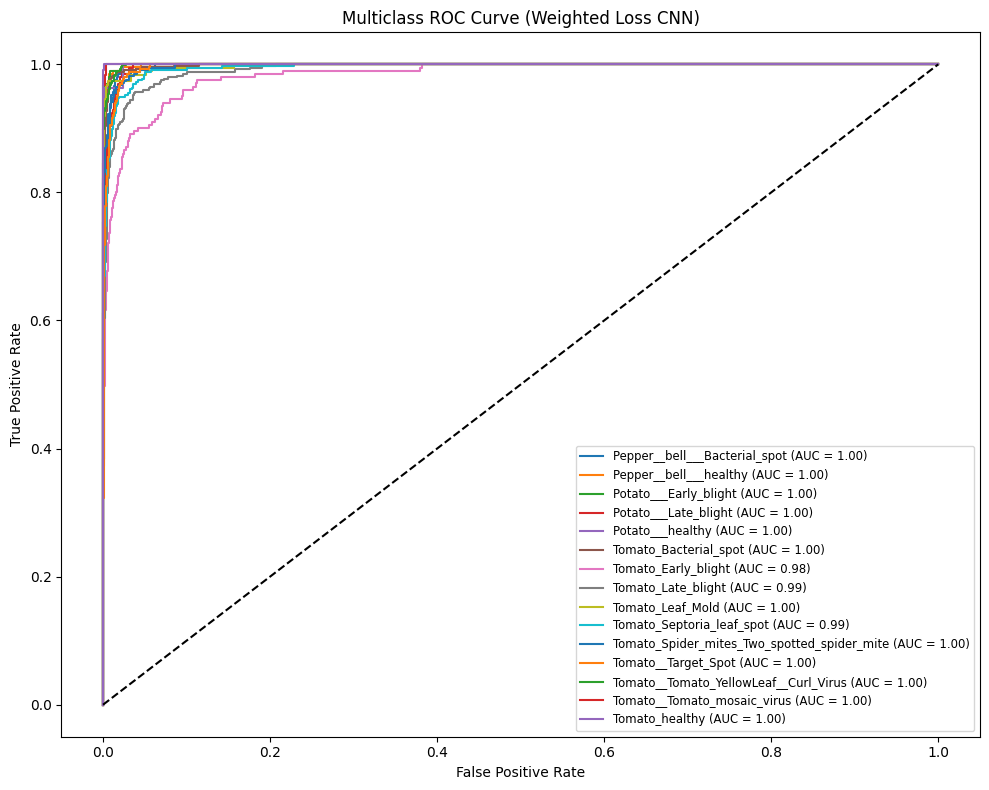

In [8]:
y_true_bin = label_binarize(all_labels, classes=range(len(class_names)))
y_score = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Weighted Loss CNN)")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.savefig("../outputs/figures/roc_curve_cnn_weighted.png")
plt.show()